In [2]:
import pandas as pd
import seaborn as sns
from enum import Enum     # for enum34, or the stdlib version
from pycaret.classification import *
from anonymizeip import anonymize_ip

class AnonTypes(Enum):
    BM = 0 # black marker 
    BI = 1 # bilateral classification
    NO = 2 # no anonymization
    
sample = 0
binary = 1

# anonymization flags
tlp_anonymization = AnonTypes.BI
ip_proto_anonymization = AnonTypes.NO
pkt_counter_anonymization = AnonTypes.NO
oct_counter_anonymization = AnonTypes.NO

In [3]:
from typing import List

def optimize_floats(df: pd.DataFrame) -> pd.DataFrame:
    floats = df.select_dtypes(include=['float64']).columns.tolist()
    df[floats] = df[floats].apply(pd.to_numeric, downcast='float')
    return df


def optimize_ints(df: pd.DataFrame) -> pd.DataFrame:
    ints = df.select_dtypes(include=['int64']).columns.tolist()
    df[ints] = df[ints].apply(pd.to_numeric, downcast='integer')
    return df


def optimize_objects(df: pd.DataFrame, datetime_features: List[str]) -> pd.DataFrame:
    for col in df.select_dtypes(include=['object']):
        if col not in datetime_features:
            if not (type(df[col][0])==list):
                num_unique_values = len(df[col].unique())
                num_total_values = len(df[col])
                if float(num_unique_values) / num_total_values < 0.5:
                    df[col] = df[col].astype('category')
        else:
            df[col] = pd.to_datetime(df[col])
    return df



def optimize(df: pd.DataFrame, datetime_features: List[str] = []):
    return optimize_floats(optimize_ints(optimize_objects(df, datetime_features)))

In [4]:
df = pd.read_csv("../NF-ToN-IoT.csv")

## Checks

In [5]:
df.columns

Index(['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT',
       'PROTOCOL', 'L7_PROTO', 'IN_BYTES', 'OUT_BYTES', 'IN_PKTS', 'OUT_PKTS',
       'TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'Label', 'Attack'],
      dtype='object')

### =================================================================

In [6]:
# Remove non-ipfix standardized features
# See: https://www.ntop.org/guides/nprobe/cli_options.html#netflow-v9-ipfix-format-t
# Thesis: Refer to table 2 for feature names and descriptions

df_ipfix = df[['L4_SRC_PORT', 'L4_DST_PORT', 'PROTOCOL', 'IN_BYTES', 'OUT_BYTES', 'IN_PKTS', 'OUT_PKTS', 'TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'Label', 'Attack']]
#df_ipfix['IPV4_SRC_ADDR'] = df_ipfix['IPV4_SRC_ADDR'].astype('category')
#df_ipfix['IPV4_DST_ADDR'] = df_ipfix['IPV4_DST_ADDR'].astype('category')

df_ipfix = optimize(df_ipfix, [])
df_ipfix.memory_usage()

Index                             128
L4_SRC_PORT                   5517096
L4_DST_PORT                   5517096
PROTOCOL                      1379274
IN_BYTES                      5517096
OUT_BYTES                     5517096
IN_PKTS                       5517096
OUT_PKTS                      5517096
TCP_FLAGS                     2758548
FLOW_DURATION_MILLISECONDS    5517096
Label                         1379274
Attack                        1379654
dtype: int64

In [7]:
df_ipfix.head()

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,63318,443,6,181,165,2,1,24,327,0,Benign
1,57442,15600,17,63,0,1,0,0,0,0,Benign
2,57452,15600,17,63,0,1,0,0,0,0,Benign
3,138,138,17,472,0,2,0,0,0,0,Benign
4,51989,15600,17,63,0,1,0,0,0,0,Benign


In [8]:
if(binary):
    df_ = df_ipfix.drop("Attack", axis=1)
else:
    df_ = df_ipfix.drop("Label", axis=1)

# Sample data
if(sample):
    df_ = df_.sample(n=50000)

## Feature Anonymization Functions

In [9]:
def anon_tlp(anon_type, df):
    if(anon_type == AnonTypes.BI): # based on - https://datatracker.ietf.org/doc/html/draft-ietf-ipfix-anon#section-4.5.1
        df['L4_SRC_PORT'] = [0 if int(x) <= 1023 else 1 for x in df['L4_SRC_PORT']]
        df['L4_DST_PORT'] = [0 if int(x) <= 1023 else 1 for x in df['L4_DST_PORT']]
    elif(anon_type == AnonTypes.BM):
        df['L4_SRC_PORT'] = 0
        df['L4_DST_PORT'] = 0
 
    return df
    
def anon_pkt_counters(anon_type, df): 
    if(anon_type == AnonTypes.BI): # based on - https://datatracker.ietf.org/doc/html/draft-ietf-ipfix-anon#section-4.4.2
        df['IN_PKTS'] = [0 if int(x) <= 2 else 1 for x in df['IN_PKTS']]
        df['OUT_PKTS'] = [0 if int(x) <= 2 else 1 for x in df['OUT_PKTS']]
    elif(anon_type == AnonTypes.BM): 
        df['IN_PKTS'] = 0
        df['OUT_PKTS'] = 0
    
    return df

def anon_octet_counters(anon_type, df): 
    mean_bytes_in = round(df_['IN_BYTES'].mean()) 
    mean_bytes_out= round(df_['OUT_BYTES'].mean()) 

    if(anon_type == AnonTypes.BI): # based on - https://datatracker.ietf.org/doc/html/draft-ietf-ipfix-anon#section-4.4.2
        df['IN_BYTES'] = [0 if int(x) <= mean_bytes_in else 1 for x in df['IN_BYTES']]
        df['OUT_BYTES'] = [0 if int(x) <= mean_bytes_out else 1 for x in df['OUT_BYTES']]
    elif(anon_type == AnonTypes.BM): 
        df['IN_BYTES'] = 0
        df['OUT_BYTES'] = 0
    
    return df

def anon_ip_proto(anon_type, df):
    grouped_protocols = [1, 6, 17] # 1, 6, and 17 for ICMP, UDP, and TCP 

    if(anon_type == AnonTypes.BI): # based on - https://datatracker.ietf.org/doc/html/draft-ietf-ipfix-anon#section-4.5.1
        df['PROTOCOL'] = [0 if int(x) in grouped_protocols else 1 for x in df['PROTOCOL']] 
    elif(anon_type == AnonTypes.BM): 
        df['PROTOCOL'] = 0
        
    return df

### Anonymization iterations 

In [10]:
#print(df_['L4_SRC_PORT'].value_counts())
df_ = anon_tlp(tlp_anonymization, df_)
df_ = anon_pkt_counters(pkt_counter_anonymization, df_)
df_ = anon_octet_counters(oct_counter_anonymization, df_)
df_ = anon_ip_proto(ip_proto_anonymization, df_)

df_.head()

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label
0,1,0,6,181,165,2,1,24,327,0
1,1,1,17,63,0,1,0,0,0,0
2,1,1,17,63,0,1,0,0,0,0
3,0,0,17,472,0,2,0,0,0,0
4,1,1,17,63,0,1,0,0,0,0


### =================================================================

In [11]:
#df_['ICMP_TYPE'] = df_['ICMP_TYPE'].astype(str)
#df_['ICMP_IPV4_TYPE'] = df_['ICMP_IPV4_TYPE'].astype(str)
categorical = ['L4_SRC_PORT', 'L4_DST_PORT', 'PROTOCOL', 'TCP_FLAGS']

for f in categorical:
    df_[f] = df_[f].astype('str')

#df_ = df_[['TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS', 'Label']]

if(binary):
    session_binary = setup(df_, target = 'Label', experiment_name='binary', categorical_features = categorical, normalize=True)
else:
    session_multi = setup(df_, target = 'Attack', experiment_name='multiclass', categorical_features = categorical, normalize=True)

,Description,Value
0,Session id,2813
1,Target,Label
2,Target type,Binary
3,Original data shape,"(1379274, 10)"
4,Transformed data shape,"(1379274, 14)"
5,Transformed train set shape,"(965491, 14)"
6,Transformed test set shape,"(413783, 14)"
7,Ordinal features,2
8,Numeric features,5
9,Categorical features,4


## Random Forest

In [12]:
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9474,0.9854,0.9431,0.9910,0.9665,0.8446,0.8502
1,0.9435,0.9852,0.9442,0.9850,0.9641,0.8316,0.8357
2,0.9452,0.9887,0.9422,0.9892,0.9651,0.8381,0.8435
3,0.9436,0.9886,0.9426,0.9866,0.9641,0.8325,0.8373
4,0.9433,0.9901,0.9426,0.9862,0.9639,0.8315,0.8361
5,0.9340,0.9886,0.9396,0.9774,0.9582,0.8025,0.8060
6,0.9384,0.9892,0.9429,0.9798,0.9610,0.8154,0.8188
7,0.9386,0.9882,0.9424,0.9804,0.9611,0.8162,0.8197
8,0.9423,0.9831,0.9437,0.9839,0.9634,0.8278,0.8318


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [13]:
predict_model(rf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9999,1.0000,0.9999,0.9999,0.9999,0.9996,0.9996


,L4_SRC_PORT,L4_DST_PORT,PROTOCOL_17,PROTOCOL_6,PROTOCOL_2,PROTOCOL_58,PROTOCOL_1,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Label,Score
965491,0.361489,-0.460295,-0.310987,0.319721,-0.065096,-0.009762,-0.01557,-0.007022,0.074205,-0.005504,-0.001015,0.504434,-0.040565,1,1,1.0
965492,0.361489,-0.460295,-0.310987,0.319721,-0.065096,-0.009762,-0.01557,-0.005457,0.116152,-0.004386,0.002253,0.485470,-0.041627,1,1,1.0
965493,0.361489,-0.460295,-0.310987,0.319721,-0.065096,-0.009762,-0.01557,-0.008926,-0.030392,-0.005877,-0.009730,0.464838,-0.055486,1,1,1.0
965494,0.361489,-0.460295,-0.310987,0.319721,-0.065096,-0.009762,-0.01557,-0.005897,-0.029197,-0.005131,-0.007551,0.485470,-0.052250,1,1,1.0
965495,-2.766332,2.172518,-0.310987,0.319721,-0.065096,-0.009762,-0.01557,-0.008868,-0.030484,-0.005877,-0.009730,0.464856,-0.004981,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1379269,0.361489,-0.460295,-0.310987,0.319721,-0.065096,-0.009762,-0.01557,-0.004692,-0.023085,-0.004759,-0.006462,0.485470,-0.054540,1,1,1.0
1379270,0.361489,-0.460295,-0.310987,0.319721,-0.065096,-0.009762,-0.01557,-0.005781,0.116152,-0.004759,0.002253,0.485470,-0.041295,1,1,1.0
1379271,0.361489,-0.460295,-0.310987,0.319721,-0.065096,-0.009762,-0.01557,-0.008926,-0.030392,-0.005877,-0.009730,0.464838,-0.055486,1,1,1.0
1379272,0.361489,-0.460295,-0.310987,0.319721,-0.065096,-0.009762,-0.01557,-0.004382,-0.023085,-0.004759,-0.006462,0.485470,-0.053644,1,1,1.0


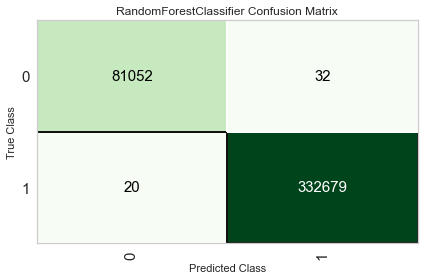

In [14]:
plot_model(rf, plot = 'confusion_matrix', plot_kwargs = {'percent' : False})


## Decision Trees

In [19]:
dt = create_model('dt') 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9288,0.9120,0.9397,0.9709,0.9550,0.7849,0.7873
1,0.9295,0.9130,0.9401,0.9713,0.9554,0.7868,0.7892
2,0.9287,0.9130,0.9388,0.9716,0.9549,0.7851,0.7877
3,0.9285,0.9133,0.9382,0.9718,0.9547,0.7845,0.7872
4,0.9281,0.9126,0.9381,0.9715,0.9545,0.7833,0.7860
5,0.9258,0.9089,0.9367,0.9700,0.9530,0.7764,0.7791
6,0.9293,0.9133,0.9396,0.9715,0.9553,0.7866,0.7891
7,0.9289,0.9144,0.9383,0.9724,0.9550,0.7861,0.7889
8,0.9274,0.9096,0.9389,0.9699,0.9541,0.7806,0.7830


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [20]:
predict_model(dt)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.9999,0.9999,1.0000,0.9999,1.0000,0.9997,0.9997


,L4_SRC_PORT,L4_DST_PORT,PROTOCOL_17,PROTOCOL_6,PROTOCOL_2,PROTOCOL_58,PROTOCOL_1,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Label,Score
965491,0.361489,-0.460295,-0.310987,0.319721,-0.065096,-0.009762,-0.01557,-0.007022,0.074205,-0.005504,-0.001015,0.504434,-0.040565,1,1,1.0
965492,0.361489,-0.460295,-0.310987,0.319721,-0.065096,-0.009762,-0.01557,-0.005457,0.116152,-0.004386,0.002253,0.485470,-0.041627,1,1,1.0
965493,0.361489,-0.460295,-0.310987,0.319721,-0.065096,-0.009762,-0.01557,-0.008926,-0.030392,-0.005877,-0.009730,0.464838,-0.055486,1,1,1.0
965494,0.361489,-0.460295,-0.310987,0.319721,-0.065096,-0.009762,-0.01557,-0.005897,-0.029197,-0.005131,-0.007551,0.485470,-0.052250,1,1,1.0
965495,-2.766332,2.172518,-0.310987,0.319721,-0.065096,-0.009762,-0.01557,-0.008868,-0.030484,-0.005877,-0.009730,0.464856,-0.004981,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1379269,0.361489,-0.460295,-0.310987,0.319721,-0.065096,-0.009762,-0.01557,-0.004692,-0.023085,-0.004759,-0.006462,0.485470,-0.054540,1,1,1.0
1379270,0.361489,-0.460295,-0.310987,0.319721,-0.065096,-0.009762,-0.01557,-0.005781,0.116152,-0.004759,0.002253,0.485470,-0.041295,1,1,1.0
1379271,0.361489,-0.460295,-0.310987,0.319721,-0.065096,-0.009762,-0.01557,-0.008926,-0.030392,-0.005877,-0.009730,0.464838,-0.055486,1,1,1.0
1379272,0.361489,-0.460295,-0.310987,0.319721,-0.065096,-0.009762,-0.01557,-0.004382,-0.023085,-0.004759,-0.006462,0.485470,-0.053644,1,1,1.0


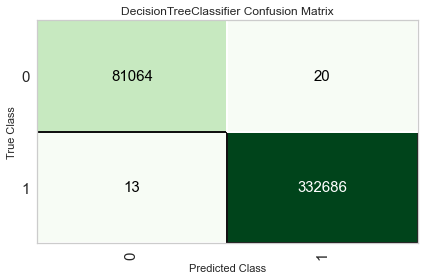

In [21]:
plot_model(dt, plot = 'confusion_matrix', plot_kwargs = {'percent' : False})

## KNN

In [22]:
knn = create_model('knn') 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9852,0.9949,0.9829,0.9986,0.9907,0.9541,0.9549
1,0.9859,0.9907,0.9838,0.9986,0.9911,0.9561,0.9568
2,0.9853,0.9906,0.9832,0.9985,0.9908,0.9544,0.9551
3,0.9852,0.9952,0.9827,0.9989,0.9907,0.9542,0.9550
4,0.9861,0.9910,0.9841,0.9986,0.9913,0.9569,0.9576
5,0.9844,0.9903,0.9823,0.9983,0.9902,0.9518,0.9525
6,0.9856,0.9907,0.9835,0.9985,0.9910,0.9553,0.9559
7,0.9855,0.9912,0.9830,0.9989,0.9909,0.9550,0.9558
8,0.9848,0.9949,0.9824,0.9987,0.9904,0.9528,0.9536


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [23]:
predict_model(knn)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.9991,0.9995,0.9995,0.9993,0.9994,0.9971,0.9971


,L4_SRC_PORT,L4_DST_PORT,PROTOCOL_17,PROTOCOL_6,PROTOCOL_2,PROTOCOL_58,PROTOCOL_1,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Label,Score
965491,0.361489,-0.460295,-0.310987,0.319721,-0.065096,-0.009762,-0.01557,-0.007022,0.074205,-0.005504,-0.001015,0.504434,-0.040565,1,1,1.0
965492,0.361489,-0.460295,-0.310987,0.319721,-0.065096,-0.009762,-0.01557,-0.005457,0.116152,-0.004386,0.002253,0.485470,-0.041627,1,1,1.0
965493,0.361489,-0.460295,-0.310987,0.319721,-0.065096,-0.009762,-0.01557,-0.008926,-0.030392,-0.005877,-0.009730,0.464838,-0.055486,1,1,1.0
965494,0.361489,-0.460295,-0.310987,0.319721,-0.065096,-0.009762,-0.01557,-0.005897,-0.029197,-0.005131,-0.007551,0.485470,-0.052250,1,1,1.0
965495,-2.766332,2.172518,-0.310987,0.319721,-0.065096,-0.009762,-0.01557,-0.008868,-0.030484,-0.005877,-0.009730,0.464856,-0.004981,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1379269,0.361489,-0.460295,-0.310987,0.319721,-0.065096,-0.009762,-0.01557,-0.004692,-0.023085,-0.004759,-0.006462,0.485470,-0.054540,1,1,1.0
1379270,0.361489,-0.460295,-0.310987,0.319721,-0.065096,-0.009762,-0.01557,-0.005781,0.116152,-0.004759,0.002253,0.485470,-0.041295,1,1,1.0
1379271,0.361489,-0.460295,-0.310987,0.319721,-0.065096,-0.009762,-0.01557,-0.008926,-0.030392,-0.005877,-0.009730,0.464838,-0.055486,1,1,1.0
1379272,0.361489,-0.460295,-0.310987,0.319721,-0.065096,-0.009762,-0.01557,-0.004382,-0.023085,-0.004759,-0.006462,0.485470,-0.053644,1,1,1.0


In [24]:
plot_model(knn, plot = 'confusion_matrix', plot_kwargs = {'percent' : False})

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

## SVM

In [25]:
svm = create_model('svm') 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9692,0.0000,0.9904,0.9719,0.9810,0.8993,0.9005
1,0.9701,0.0000,0.9905,0.9728,0.9816,0.9023,0.9033
2,0.9699,0.0000,0.9899,0.9732,0.9815,0.9020,0.9029
3,0.9685,0.0000,0.9891,0.9722,0.9806,0.8973,0.8982
4,0.9703,0.0000,0.9905,0.9731,0.9817,0.9032,0.9042
5,0.9679,0.0000,0.9890,0.9716,0.9802,0.8952,0.8962
6,0.9682,0.0000,0.9900,0.9710,0.9804,0.8959,0.8971
7,0.9699,0.0000,0.9906,0.9724,0.9814,0.9015,0.9026
8,0.9697,0.0000,0.9899,0.9729,0.9813,0.9012,0.9021


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [26]:
predict_model(svm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Linear Kernel,0.9694,0.9373,0.9901,0.9724,0.9812,0.9001,0.9012


,L4_SRC_PORT,L4_DST_PORT,PROTOCOL_17,PROTOCOL_6,PROTOCOL_2,PROTOCOL_58,PROTOCOL_1,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Label
965491,0.361489,-0.460295,-0.310987,0.319721,-0.065096,-0.009762,-0.01557,-0.007022,0.074205,-0.005504,-0.001015,0.504434,-0.040565,1,1
965492,0.361489,-0.460295,-0.310987,0.319721,-0.065096,-0.009762,-0.01557,-0.005457,0.116152,-0.004386,0.002253,0.485470,-0.041627,1,1
965493,0.361489,-0.460295,-0.310987,0.319721,-0.065096,-0.009762,-0.01557,-0.008926,-0.030392,-0.005877,-0.009730,0.464838,-0.055486,1,1
965494,0.361489,-0.460295,-0.310987,0.319721,-0.065096,-0.009762,-0.01557,-0.005897,-0.029197,-0.005131,-0.007551,0.485470,-0.052250,1,1
965495,-2.766332,2.172518,-0.310987,0.319721,-0.065096,-0.009762,-0.01557,-0.008868,-0.030484,-0.005877,-0.009730,0.464856,-0.004981,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1379269,0.361489,-0.460295,-0.310987,0.319721,-0.065096,-0.009762,-0.01557,-0.004692,-0.023085,-0.004759,-0.006462,0.485470,-0.054540,1,1
1379270,0.361489,-0.460295,-0.310987,0.319721,-0.065096,-0.009762,-0.01557,-0.005781,0.116152,-0.004759,0.002253,0.485470,-0.041295,1,1
1379271,0.361489,-0.460295,-0.310987,0.319721,-0.065096,-0.009762,-0.01557,-0.008926,-0.030392,-0.005877,-0.009730,0.464838,-0.055486,1,1
1379272,0.361489,-0.460295,-0.310987,0.319721,-0.065096,-0.009762,-0.01557,-0.004382,-0.023085,-0.004759,-0.006462,0.485470,-0.053644,1,1


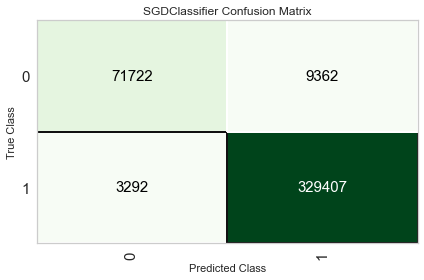

In [27]:
plot_model(svm, plot = 'confusion_matrix', plot_kwargs = {'percent' : False})